<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep1-eda-modeling-submission?scriptVersionId=157495308" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (01/01/2024)

    - EDA and baseline modeling 1.0
    

- Version 2 (01/02/2023)
    
    - Baseline modeling 1.0 updated
    

# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [2]:
train = pd.read_csv('../input/playground-series-s4e1/train.csv')
train['Age'] = train['Age'].astype(int)
train['NumOfProducts'] = train['NumOfProducts'].astype(int)
train['HasCrCard'] = train['HasCrCard'].astype(int)
train['IsActiveMember'] = train['IsActiveMember'].astype(int)

test = pd.read_csv('../input/playground-series-s4e1/test.csv')
test['Age'] = test['Age'].astype(int)
test['NumOfProducts'] = test['NumOfProducts'].astype(int)
test['HasCrCard'] = test['HasCrCard'].astype(int)
test['IsActiveMember'] = test['IsActiveMember'].astype(int)

submission = pd.read_csv('../input/playground-series-s4e1/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (165034, 14)
The dimension of the test dataset is: (110023, 13)


In [3]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33,3,0.00,2,1,0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33,5,0.00,2,1,1,15068.83,0


In [4]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23,2,0.00,2,0,1,160976.75
1,165035,15782418,Nott,683,France,Female,46,2,0.00,1,1,0,72549.27
2,165036,15807120,K?,656,France,Female,34,7,0.00,2,1,0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36,8,0.00,1,1,0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38,10,121263.62,1,1,0,139431.00


There are no missing values neither in the `train` nor `test` datasets.

# Data Exploration

First, we start by visualizing `Exited`, the variable of interest.

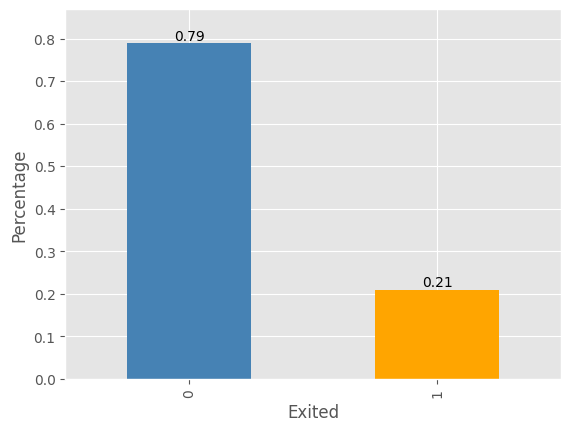

In [5]:
ax = round(train['Exited'].value_counts(normalize = True), 2).plot(kind = 'bar', color = ['steelblue', 'orange'])
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.margins(y = 0.1)
plt.ylabel('Percentage');

From the above chart, it is clear the data is imbalanced. Next, we explore the relationship between `Exited` and the input features.

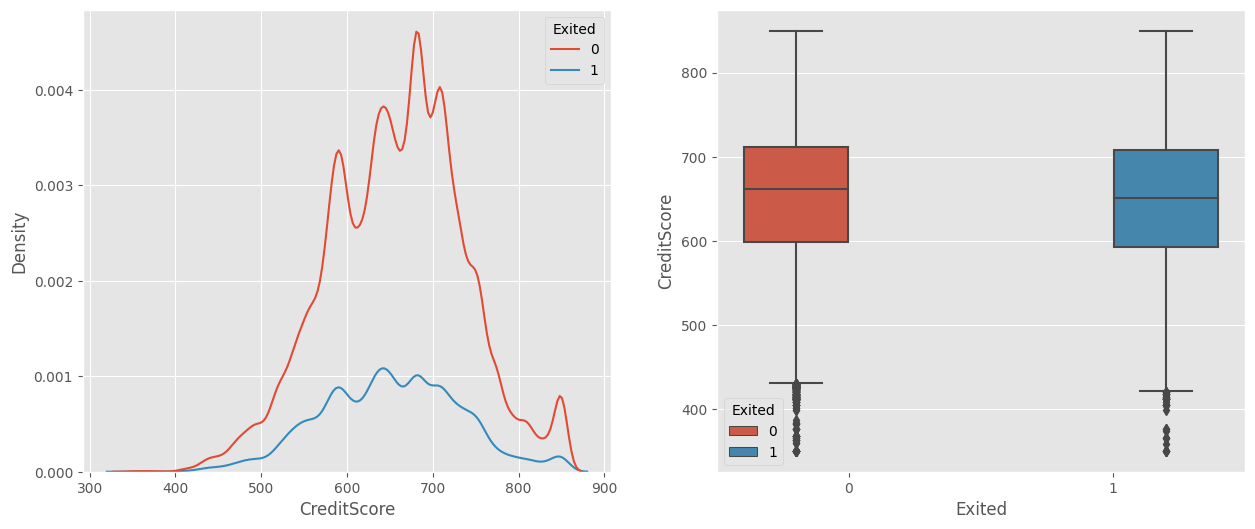

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.kdeplot(ax = axes[0], data = train, x = 'CreditScore', hue = 'Exited')
sns.boxplot(ax = axes[1], data = train, x = 'Exited', y = 'CreditScore', hue = 'Exited');

From the above plots, these are a couple of observations:

- Both group distributions are similar.
- The distributions seem to be left-skewed.

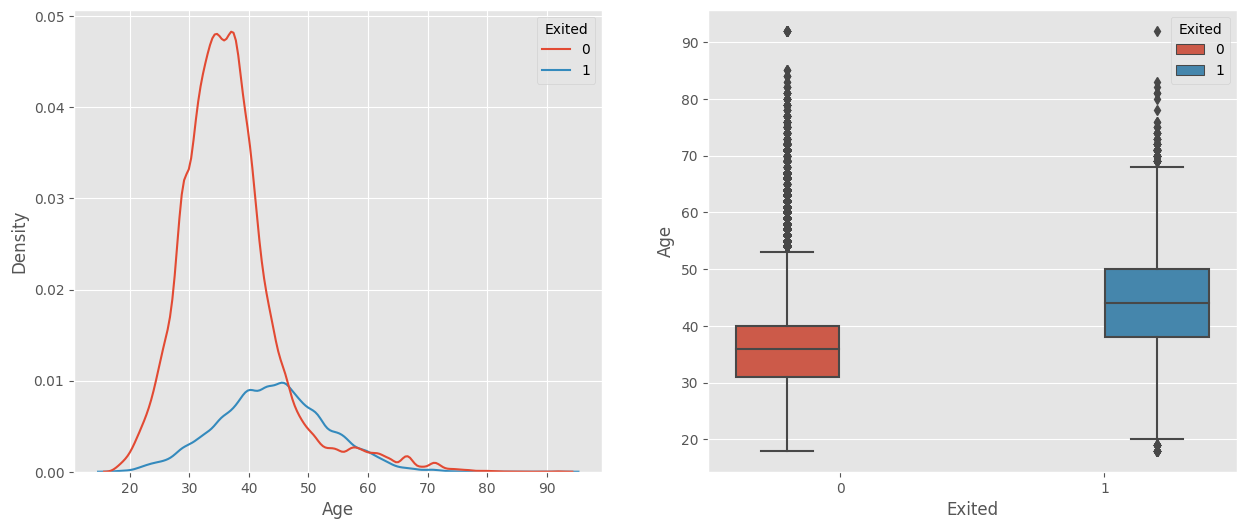

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.kdeplot(ax = axes[0], data = train, x = 'Age', hue = 'Exited')
sns.boxplot(ax = axes[1], data = train, x = 'Exited', y = 'Age', hue = 'Exited');

From the above plots, these are a couple of observations:

- Both group distributions are right-skewed.
- Customers with `Exited = 1`, on average, are older.

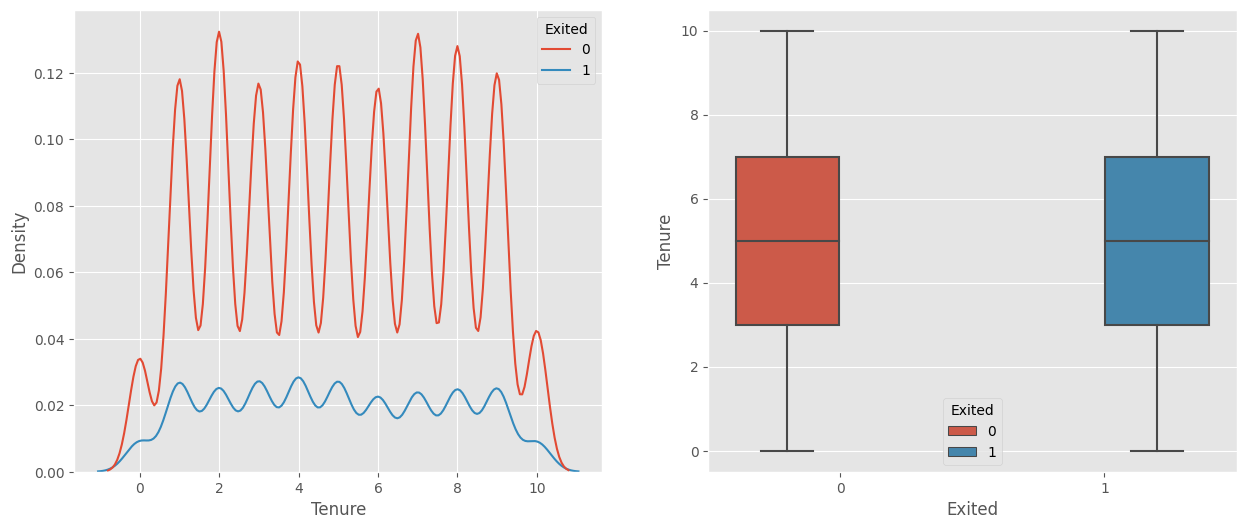

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.kdeplot(ax = axes[0], data = train, x = 'Tenure', hue = 'Exited')
sns.boxplot(ax = axes[1], data = train, x = 'Exited', y = 'Tenure', hue = 'Exited');

From the above plots, these are a couple of observations:

- Both group distributions are very similar.
- The distribution of `Tenure` is multi-modal.

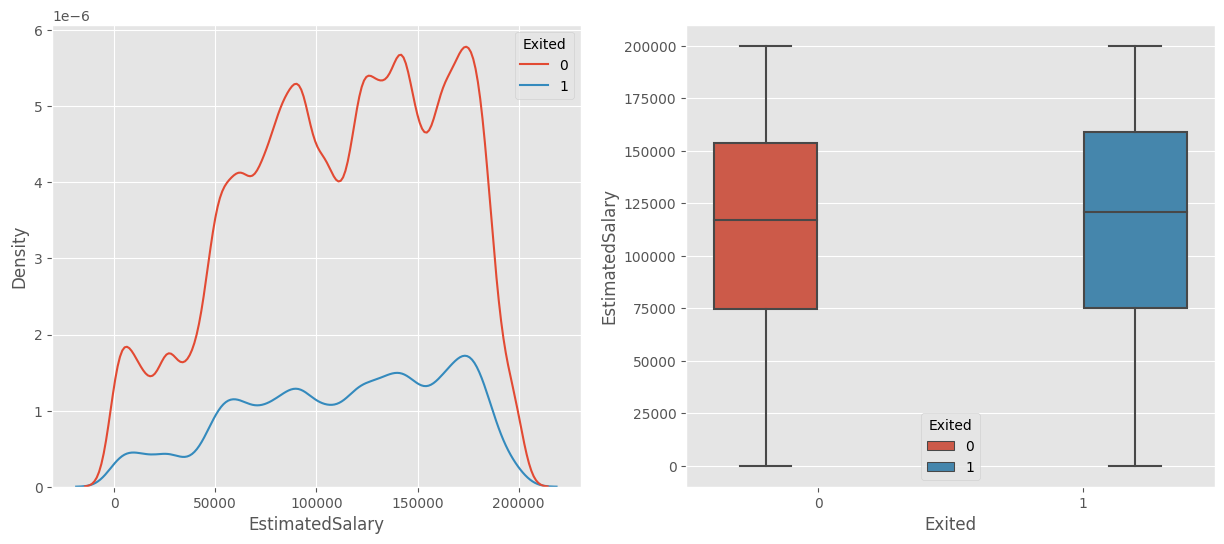

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.kdeplot(ax = axes[0], data = train, x = 'EstimatedSalary', hue = 'Exited')
sns.boxplot(ax = axes[1], data = train, x = 'Exited', y = 'EstimatedSalary', hue = 'Exited');

From the above plots, these are a couple of observations:

- Both group distributions are very similar.
- The distribution of `EstimatedSalary` is multi-modal.

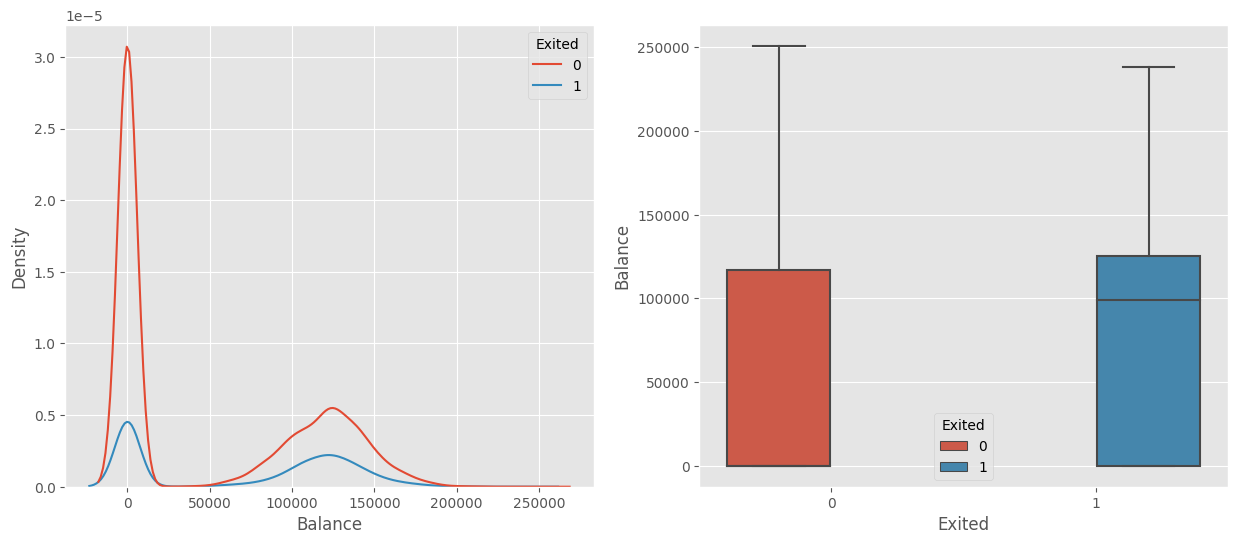

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.kdeplot(ax = axes[0], data = train, x = 'Balance', hue = 'Exited')
sns.boxplot(ax = axes[1], data = train, x = 'Exited', y = 'Balance', hue = 'Exited');

From the above plots, these are a couple of observations:

- Both group distributions are very similar.
- The distribution of `Balance` is bi-modal. Does a 0 `Balance` mean `NA`?

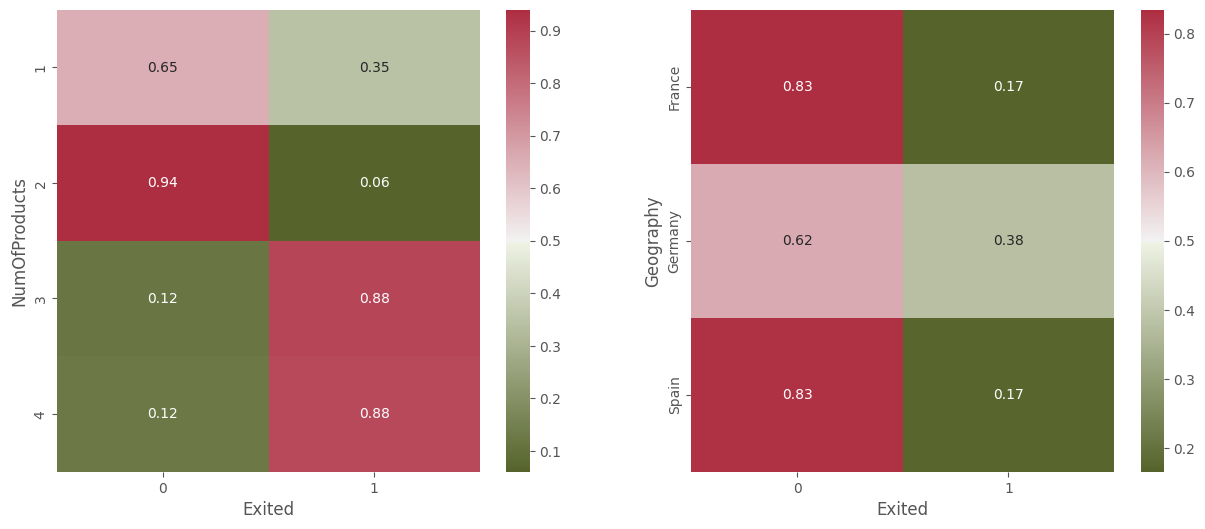

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['NumOfProducts'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Geography'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above plots, these are a couple of observations:

- The likehood of `Exited` is higher when `NumOfProducts >= 3`.
- `Germany` has the higher likelihood of `Exited` compared to the other two countries.

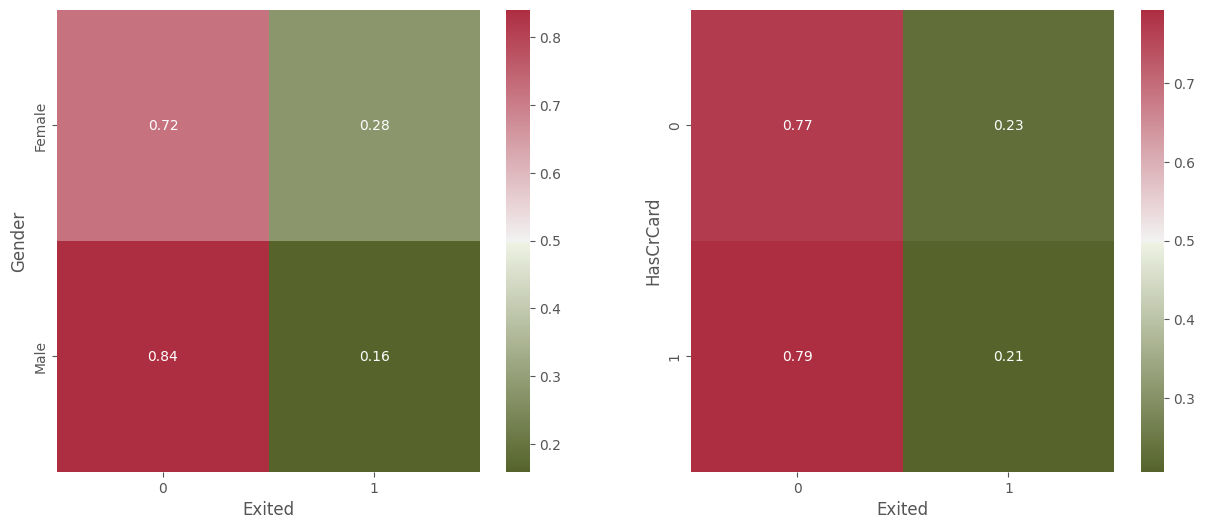

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Gender'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['HasCrCard'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- `Female` has a higher likelihood of `Exited`.
- The likelihood of `Exited` is about the same regardless of `HasCrCard` label.

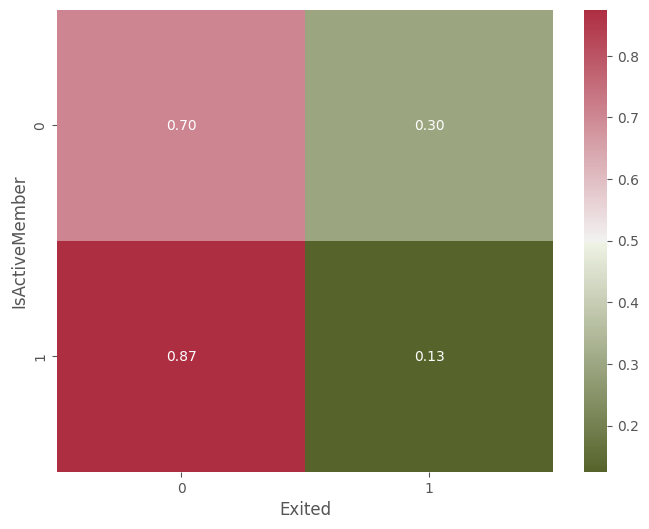

In [13]:
plt.figure(figsize = (8, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(data = pd.crosstab(train['IsActiveMember'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above chart, `IsActiveMember = 0` customers are more likely to `Exited`.

# Baseline Modeling 1.0

In this section, we start by modeling (using standard models) with raw data with minimum transformation. First, we define the input, target variables and the cross-validation folds.

In [14]:
X = train.drop(columns = ['id', 'CustomerId', 'Surname', 'Exited'], axis = 1)
X['Gender'] = X['Gender'].map({'Female': 0, 'Male': 1})
X = pd.concat([X.drop(columns = ['Geography'], axis = 1), pd.get_dummies(train['Geography'], drop_first = True, dtype = int)], axis = 1)

Y = train['Exited']

test_md = test.drop(columns = ['id', 'CustomerId', 'Surname'], axis = 1)
test_md['Gender'] = test_md['Gender'].map({'Female': 0, 'Male': 1})
test_md = pd.concat([test_md.drop(columns = ['Geography'], axis = 1), pd.get_dummies(test_md['Geography'], drop_first = True, dtype = int)], axis = 1)

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

First, we train the `LogisticRegression` model.

In [15]:
%%time
logit_cv = cross_val_score(make_pipeline(PowerTransformer(), LogisticRegression()), 
                           X, 
                           Y, 
                           scoring = 'roc_auc',
                           cv = skf, 
                           n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the Logistic Regression is {logit_cv.mean()}")

The average 10-folds oof ROC-AUC score of the Logistic Regression is 0.8264336332489346
CPU times: user 247 ms, sys: 154 ms, total: 402 ms
Wall time: 11.4 s


Next, we train the `RandomForest` model.

In [16]:
%%time
RF_cv = cross_val_score(RandomForestClassifier(n_estimators = 100,
                                               max_depth = 3,
                                               min_samples_leaf = 3,
                                               random_state = 10,
                                               n_jobs = -1),
                        X, 
                        Y, 
                        scoring = 'roc_auc',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the Random Forest is {RF_cv.mean()}")

The average 10-folds oof ROC-AUC score of the Random Forest is 0.8649378691437668
CPU times: user 333 ms, sys: 119 ms, total: 452 ms
Wall time: 43.2 s


Next, we train the `ExtraTrees` model.

In [17]:
%%time
ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 100,
                                             max_depth = 5,
                                             min_samples_leaf = 3, 
                                             random_state = 1,
                                             n_jobs = -1),
                        X, 
                        Y, 
                        scoring = 'roc_auc',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the Extra Trees is {ET_cv.mean()}")

The average 10-folds oof ROC-AUC score of the Extra Trees is 0.8584430392211253
CPU times: user 302 ms, sys: 99.3 ms, total: 401 ms
Wall time: 38.6 s


Next, we train the `GradientBoosting` model.

In [18]:
%%time
GB_cv = cross_val_score(GradientBoostingClassifier(n_estimators = 100,
                                                   learning_rate = 0.1,
                                                   max_depth = 4, 
                                                   min_samples_leaf = 5, 
                                                   subsample = 0.8,
                                                   random_state = 1),
                        X, 
                        Y, 
                        scoring = 'roc_auc',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the Gradient Boosting is {GB_cv.mean()}")

The average 10-folds oof ROC-AUC score of the Gradient Boosting is 0.8893074354480923
CPU times: user 871 ms, sys: 300 ms, total: 1.17 s
Wall time: 1min 59s


Next, we train the `HistGradientBoosting` model.

In [19]:
%%time
HG_cv = cross_val_score(HistGradientBoostingClassifier(max_iter = 100,
                                                       max_depth = 4,
                                                       random_state = 10), 
                        X, 
                        Y, 
                        scoring = 'roc_auc',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the HistGradient is {HG_cv.mean()}")

The average 10-folds oof ROC-AUC score of the HistGradient is 0.8892437595895357
CPU times: user 183 ms, sys: 54.2 ms, total: 237 ms
Wall time: 12.5 s


Next, we train the `LGBMClassifier` model.

In [20]:
%%time
LGBM_cv = cross_val_score(LGBMClassifier(n_estimators = 100,
                                         max_depth = 5,
                                         num_leaves = 30, 
                                         subsample = 0.7,
                                         random_state = 10), 
                          X, 
                          Y, 
                          scoring = 'roc_auc',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the LGBM is {LGBM_cv.mean()}")

The average 10-folds oof ROC-AUC score of the LGBM is 0.8895094066930204
CPU times: user 299 ms, sys: 90.9 ms, total: 390 ms
Wall time: 28.3 s


Next, we train the `XGBClassifier` model.

In [21]:
%%time
XGB_cv = cross_val_score(XGBClassifier(n_estimators = 100,
                                       max_depth = 4,
                                       min_child_weight = 15, 
                                       subsample = 0.9,
                                       random_state = 20), 
                         X, 
                         Y, 
                         scoring = 'roc_auc',
                         cv = skf, 
                         n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the XGB is {XGB_cv.mean()}")

The average 10-folds oof ROC-AUC score of the XGB is 0.8892986418714364
CPU times: user 276 ms, sys: 71.6 ms, total: 347 ms
Wall time: 22.4 s


Next, we train the `MLPClassifier` model.

In [22]:
%%time
to_tran_power = ['Age', 'Tenure', 'EstimatedSalary', 'Balance', 'CreditScore']

power_tran = ColumnTransformer([('stand', PowerTransformer(), to_tran_power)],
                                 remainder = 'passthrough')

MLP_cv = cross_val_score(Pipeline([('transformation', power_tran),
                                   ('MLP', MLPClassifier(hidden_layer_sizes = (16, 16),
                                                         activation = 'relu',
                                                         random_state = 10))]),
                         X, 
                         Y, 
                         scoring = 'roc_auc',
                         cv = skf, 
                         n_jobs = -1)

print(f"The average 10-folds oof ROC-AUC score of the MLP is {MLP_cv.mean()}")

The average 10-folds oof ROC-AUC score of the MLP is 0.8873377177445807
CPU times: user 1.96 s, sys: 638 ms, total: 2.6 s
Wall time: 4min 30s


Then, we consolidate the different model results into a table.

In [23]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['Logistic', 'RF', 'ET', 'GB', 'Hist', 'LGBM', 'XGB', 'MLP']
model_performance['10-folds oof ROC-AUC'] = [logit_cv.mean(), RF_cv.mean(), ET_cv.mean(), GB_cv.mean(), HG_cv.mean(), 
                                             LGBM_cv.mean(), XGB_cv.mean(), MLP_cv.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

      Model  10-folds oof ROC-AUC
0  Logistic              0.826434
1        RF              0.864938
2        ET              0.858443
3        GB              0.889307
4      Hist              0.889244
5      LGBM              0.889509
6       XGB              0.889299
7       MLP              0.887338


Next, we build a `VotingClassifier` model with the top five models.

In [24]:
md1 = GradientBoostingClassifier(n_estimators = 100,
                                 learning_rate = 0.1,
                                 max_depth = 4, 
                                 min_samples_leaf = 5, 
                                 subsample = 0.8,
                                 random_state = 1)

md2 = HistGradientBoostingClassifier(max_iter = 100,
                                     max_depth = 4,
                                     random_state = 10)

md3 = LGBMClassifier(n_estimators = 100,
                     max_depth = 5,
                     num_leaves = 30, 
                     subsample = 0.7,
                     random_state = 10)


to_tran_power = ['Age', 'Tenure', 'EstimatedSalary', 'Balance', 'CreditScore']
power_tran = ColumnTransformer([('stand', PowerTransformer(), to_tran_power)],
                                 remainder = 'passthrough')

md4 = Pipeline([('transformation', power_tran),
                ('MLP', MLPClassifier(hidden_layer_sizes = (16, 16),
                                                         activation = 'relu',
                                                         random_state = 10))])

md5 = XGBClassifier(n_estimators = 100,
                    max_depth = 4,
                    min_child_weight = 15, 
                    subsample = 0.9,
                    random_state = 20)


voting_md = VotingClassifier(estimators = [('GB', md1),
                                           ('HB', md2), 
                                           ('LGBM', md3), 
                                           ('MLP', md4), 
                                           ('XGB', md5)],
                             voting = 'soft',
                             weights = [1/5, 1/5, 1/5, 1/5, 1/5])

voting_md

VotingClassifier(estimators=[('GB',
                              GradientBoostingClassifier(max_depth=4,
                                                         min_samples_leaf=5,
                                                         random_state=1,
                                                         subsample=0.8)),
                             ('HB',
                              HistGradientBoostingClassifier(max_depth=4,
                                                             random_state=10)),
                             ('LGBM',
                              LGBMClassifier(max_depth=5, num_leaves=30,
                                             random_state=10, subsample=0.7)),
                             ('MLP',
                              Pipeline(steps=[('transformation',
                                               ColumnTransformer(remainder='passthro...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=15, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=20, ...))],
                 voting='soft', weights=[0.2, 0.2, 0.2, 0.2, 0.2])

Next, we evaluate the performance of the `VotingClassifier`.

In [25]:
%%time
vot_cv = cross_val_score(voting_md, 
                         X, 
                         Y, 
                         cv = skf,
                         scoring = 'roc_auc',
                         n_jobs = -1)

print(f"The 10 folds oof ROC-AUC score of Voting Classifier is {vot_cv.mean()}")

The 10 folds oof ROC-AUC score of Voting Classifier is 0.889823929646011
CPU times: user 4.57 s, sys: 1.48 s, total: 6.05 s
Wall time: 10min 35s


Next, we build a `StackingClassifier` model with the top five models.

In [26]:
stacker_md = StackingClassifier(estimators = [('GB', md1),
                                              ('HB', md2), 
                                              ('LGBM', md3), 
                                              ('MLP', md4), 
                                              ('XGB', md5)],
                                final_estimator = LogisticRegression(),
                                stack_method = 'predict_proba', 
                                n_jobs = -1)

stacker_md

StackingClassifier(estimators=[('GB',
                                GradientBoostingClassifier(max_depth=4,
                                                           min_samples_leaf=5,
                                                           random_state=1,
                                                           subsample=0.8)),
                               ('HB',
                                HistGradientBoostingClassifier(max_depth=4,
                                                               random_state=10)),
                               ('LGBM',
                                LGBMClassifier(max_depth=5, num_leaves=30,
                                               random_state=10,
                                               subsample=0.7)),
                               ('MLP',
                                Pipeline(steps=[('transformation',
                                                 ColumnTransformer(remainder='passth...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=15, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=20, ...))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   stack_method='predict_proba')

Next, we evaluate the performance of the `StackingClassifier`.

In [27]:
%%time
stack_cv = cross_val_score(stacker_md, 
                           X, 
                           Y, 
                           cv = skf,
                           scoring = 'roc_auc',
                           n_jobs = -1)

print(f"The 10 folds oof ROC-AUC score of Stacker Classifier is {stack_cv.mean()}")

The 10 folds oof ROC-AUC score of Stacker Classifier is 0.8897332186122571
CPU times: user 22.9 s, sys: 7.42 s, total: 30.4 s
Wall time: 57min 23s


Finally, we average the predictions of the `VotingClassifier` and `StackingClassifier`

In [28]:
%%time
vot_md = voting_md.fit(X, Y)
stack_md = stacker_md.fit(X, Y)

submission['Exited'] = (vot_md.predict_proba(test_md)[:, 1] + stack_md.predict_proba(test_md)[:, 1]) / 2
submission.head()

CPU times: user 8min, sys: 3.35 s, total: 8min 3s
Wall time: 7min 41s


,id,Exited
0,165034,0.038522
1,165035,0.830265
2,165036,0.039009
3,165037,0.211144
4,165038,0.302900


In [29]:
submission.to_csv('baseline_sub_1.csv', index = False)